# dogs vs. cats redux kernels edition

A rewrite of the redux notebook that prepares output to submit to the redux cats vs. dogs competition.  This time writing the code 'from scratch', suppobred by the source code for vgg16.py and utils.py, and the keras documentation.

I prepared the redux data in the lesson1/redux notebook so I'm skipping that step here.

These are the steps I'm going to follow:
1. Set up the architecture
1. Train the model
1. Run the model on the test sets
1. Print out submittion file
1. Submit to Kaggle

## Basic setup

To be able to plot images in the jupyter notebook:

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [54]:
data_path = "/home/ubuntu/nbs/data/redux/"
sample_path = "/home/ubuntu/nbs/data/redux/sample/"

A few basic libraries that we'll need for the initial exercises:

In [45]:
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import random
import json

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots
import shutil

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


In [11]:
import numpy as np


## Set up the architecture

In [17]:
#I'm guessing this is just creating a linear model
def preprocess(x):
    x = x - np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
    return x[:, ::-1] # reverse axis bgr->rgb

In [21]:
model = Sequential()
model.add(Lambda(preprocess, input_shape=(3,224,224)))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
Total params: 0
____________________________________________________________________________________________________


In [42]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_3[0][0]            
____________________________________________________________________________________________________
zeropadding2d_4 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_3[0][0]            
___________________________________________________________________________________________

In [23]:
model.get_weights()

[]

In [25]:
model.get_config()

[{'class_name': 'Lambda',
  'config': {'arguments': {},
   'batch_input_shape': (None, 3, 224, 224),
   'function': (u'c\x01\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00C\x00\x00\x00sB\x00\x00\x00|\x00\x00t\x00\x00j\x01\x00d\x01\x00d\x02\x00d\x03\x00g\x03\x00\x83\x01\x00j\x02\x00d\x07\x00\x83\x01\x00\x18}\x00\x00|\x00\x00d\x00\x00d\x00\x00\x85\x02\x00d\x00\x00d\x00\x00d\x06\x00\x85\x03\x00f\x02\x00\x19S(\x08\x00\x00\x00Ng\xecQ\xb8\x1e\x85\xeb^@g`\xe5\xd0"\xdb1]@gj\xbct\x93\x18\xfcY@i\x03\x00\x00\x00i\x01\x00\x00\x00i\xff\xff\xff\xff(\x03\x00\x00\x00i\x03\x00\x00\x00i\x01\x00\x00\x00i\x01\x00\x00\x00(\x03\x00\x00\x00t\x02\x00\x00\x00npt\x05\x00\x00\x00arrayt\x07\x00\x00\x00reshape(\x01\x00\x00\x00t\x01\x00\x00\x00x(\x00\x00\x00\x00(\x00\x00\x00\x00s\x1f\x00\x00\x00<ipython-input-17-5e236a6f1e15>t\n\x00\x00\x00preprocess\x02\x00\x00\x00s\x04\x00\x00\x00\x00\x01%\x01',
    None,
    None),
   'function_type': 'lambda',
   'input_dtype': 'float32',
   'name': 'lambda_4',
   'output_shape': 

In [41]:
def add_conv_block(model, layers, filters):
    for i in range(layers):
        #Zero-padding layer for 2D input (e.g. picture).
        #Adding zeros at end of rows and cols
        model.add(ZeroPadding2D((1, 1)))
        #Convolution operator for filtering windows of two-dimensional inputs.
        #Convolution2d is a type of linear layer, like Dense.
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [37]:
## Adding Convolutional Blocks:
add_conv_block(model,2, 64)
add_conv_block(model,2, 128)
add_conv_block(model,3, 256)
add_conv_block(model,3, 512)
add_conv_block(model,3, 512)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_3[0][0]            
____________________________________________________________________________________________________
zeropadding2d_4 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_3[0][0]            
___________________________________________________________________________________________

In [39]:
def add_fully_connected_block(model): 
    #A Dense() layer is just a linear model, followed by a simple activation function
    # A linear model is simply a model where each row is calculated as sum(row * weights), where weights needs to be learnt from the data
    model.add(Dense(4096,activation='relu'))

    #Drop out to avoid overfitting.  0.5 means 50% of results are dropped
    model.add(Dropout(0.5))

In [40]:
#Flattens the input. Does not affect the batch size.  Flattens the input into a single vector.
model.add(Flatten())
add_fully_connected_block(model)
add_fully_connected_block(model)
#We want 1000 outputs for each image, one for each class in image.net
model.add(Dense(1000,activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_3[0][0]            
____________________________________________________________________________________________________
zeropadding2d_4 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_3[0][0]            
___________________________________________________________________________________________

In [43]:
#Load the weights form the pretrained model
model.load_weights(get_file('vgg16.h5', 'http://www.platform.ai/models/vgg16.h5', cache_subdir='models'))

In [46]:
fname = 'imagenet_class_index.json'
fpath = get_file(fname, 'http://www.platform.ai/models/'+fname, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
classes[:10]

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich']

In [60]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64
path = sample_path

In [57]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8):
    return gen.flow_from_directory(path, target_size=(224,224),
            class_mode='categorical', shuffle=shuffle, batch_size=batch_size)

train_batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 204 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [58]:
#The weights I'm using are from a model that had 1000 cat as output.  
#Do I need to pop here or can I simply change the original model?
#Finetune the model by removing the last layer and adding a new one 
model.pop()
for layer in model.layers:
    layer.trainable=False
model.add(Dense(train_batches.nb_class, activation='softmax', input_shape=(1000,)))
model.compile(optimizer=RMSprop(lr=0.1),
        loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_3[0][0]            
____________________________________________________________________________________________________
zeropadding2d_4 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_3[0][0]            
___________________________________________________________________________________________

In [61]:
#Fits the model on data generated batch-by-batch by a Python generator. 
#The generator is run in parallel to the model, for efficiency. 
#For instance, this allows you to do real-time data augmentation on images 
#on CPU in parallel to training your model on GPU.  
model.fit_generator(train_batches,
                    samples_per_epoch=train_batches.nb_sample, 
                    nb_epoch=1,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.nb_sample)


Epoch 1/1
204/204 [==============================] - 99s - loss: 1.0431 - acc: 0.9314 - val_loss: 2.1979 - val_acc: 0.8636


In [63]:
#Save the weights created by the training for later use
if not os.path.exists(path+'results'):
    os.makedirs(path+'results')

model.save_weights(path+'results/ft1.h5')

In [67]:
#Run a few more epocs to train the model better:
model.fit_generator(train_batches,
                    samples_per_epoch=train_batches.nb_sample, 
                    nb_epoch=1,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.nb_sample)

Epoch 1/1
204/204 [==============================] - 99s - loss: 1.0272 - acc: 0.9363 - val_loss: 0.7217 - val_acc: 0.9545


In [65]:
vgg.model.save_weights(path+'results/ft2.h5')

NameError: name 'vgg' is not defined

# Submit

In [7]:
batch_size=64

In [8]:
path = data_path
model.load_weights(path+'results/ft2.h5')

#batches, preds = vgg.test(path+'test', batch_size = batch_size*2)

test_batches = image.ImageDataGenerator().flow_from_directory(path+'test',target_size=(224,224),class_mode='categorical', shuffle=True,batch_size = batch_size*2)
preds = model.predict_generator(test_batches, test_batches.nb_sample)

Found 12500 images belonging to 1 classes.


In [9]:
filenames = batches.filenames

In [10]:
preds[:5]

array([[  1.0000e+00,   0.0000e+00],
       [  5.9880e-32,   1.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  0.0000e+00,   1.0000e+00]], dtype=float32)

In [19]:
filenames[:5]

12500

In [20]:
utils.save_array(path+'results/test_preds.dat', preds)
utils.save_array(path+'results/filenames.dat', filenames)

In [21]:
preds = utils.load_array('results/test_preds.dat')
filenames = utils.load_array('results/filenames.dat')

IOError: [Errno 2] No such file or directory: 'results/test_preds.dat/meta/sizes'

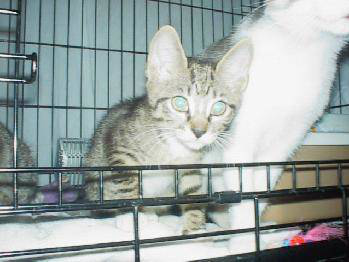

In [24]:
from PIL import Image
Image.open(test_path+filenames[0])

In [25]:
isdog = preds[:,1]
isdog[:5]

array([ 0.,  1.,  0.,  0.,  1.], dtype=float32)

In [26]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [27]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   0.0000e+00],
       [  1.2026e+04,   1.0000e+00],
       [  9.6880e+03,   0.0000e+00],
       [  4.3920e+03,   0.0000e+00],
       [  7.7900e+02,   1.0000e+00]])

In [28]:
np.savetxt('data/redux/subm98.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [29]:
from IPython.display import FileLink
FileLink('data/redux/subm98.csv')

/home/ubuntu/nbs/data/redux/subm98.csv